# Part 2 - Preparing the rainfall input data

In this notebook demonstrates how the rainfall data is extracted from RADKLIM data as time series for every subbasins and how the counterfactuals are created. In the second part we calculate the effective rainfall time series. For this example we supply the RADKLIM (v2017.002) data for the event NW/Jul21 which has been downloaded from the RADKLIM data from the DWD Open Data Server (Winterrath et al., 2018). The files were then compiled using the package radolan_to_netcdf (Chwala, 2021).
We supply following data:
   - *nw_jul21.nc*: NetCDF containing the RADKLIM precipitation estimates for the NW/JUL21 event.
  
We then compute the precipitation time series for all subbasins for the NW/Jul21 event and create counterfactuals by moving the centroid (cell with the highest hourly rainfall) to every subbasin in the data set. The subbasin ID therefore also describes a counterfactual later on.

This script is based on the tutorial on the wradlib (Heistermann et al., 2013, tutorial: https://docs.wradlib.org/en/latest/notebooks/workflow/recipe5.html). Unlike other packages the extraction of rainfall series for subbasins is quite precise. With the 1 km grid of RADKLIM some cells might cover a subbasin just a little bit. The wradlib algorithm computes the weighted areal average, while most other methods either use the average of all fully included cells, or the average of all cells with an overlap.

As a second step we also calculate the effective precipitation from the RADKLIM precipitation time series by using the SCS-CN method (U.S. Department of Agriculture-Soil Conservation Service, 1972).
Finally, the user can visualize the spatial position of the counterfactuals.

In [19]:
import pandas as pd
import counterfactual_precipitation as cp
import geopandas as gpd
import pyproj
from osgeo import osr
import wradlib as wrl
import os
import xarray as xr
import numpy as np

In [3]:
# create the files for the projection information
radolanwkt = """PROJCS["Radolan Projection",
    GEOGCS["Radolan Coordinate System",
        DATUM["Radolan_Kugel",
            SPHEROID["Erdkugel",6370040,0]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]]],
    PROJECTION["Polar_Stereographic"],
    PARAMETER["latitude_of_origin",90],
    PARAMETER["central_meridian",10],
    PARAMETER["scale_factor",0.933012701892],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["kilometre",1,
        AUTHORITY["EPSG","9036"]],
    AXIS["Easting",SOUTH],
    AXIS["Northing",SOUTH]]
"""
radolanproj = pyproj.CRS.from_wkt(radolanwkt)
proj_stereo = wrl.georef.create_osr("dwd-radolan-sphere")

# This is our target projection (UTM)
proj_utm = osr.SpatialReference()
proj_utm.ImportFromEPSG(32632)


event_id = "WG/Jul21"
subbasins = gpd.read_file("output/gis/subbasins_info.gpkg")
#project the subbasin shapefile to UTM
subbasins_utm = subbasins.to_crs("EPSG:32632")
subbasins_utm = subbasins_utm[["sub_id", "geometry"]]
subbasins_utm.to_file("output/gis/subbasins_utm.gpkg")

subbasins = subbasins.to_crs(radolanproj)

event = xr.open_dataset("input/nw_jul21.nc")
event = event.rainfall_amount

#get the coordinates of the centroid
t_max, y_max, x_max = np.argwhere(event.values == np.nanmax(event.values))[0]
centroid_x_coord = event.x[x_max].item()
centroid_y_coord = event.y[y_max].item()
original_centroid = (centroid_x_coord, centroid_y_coord)

if not os.path.exists("output/precipitation"):
    os.mkdir("output/precipitation")

## Extract precipitation time series for the original event (-999) and all counterfactuals
For this we use the same function as below but we manipulate the subbasin shapefile and add one basin, which has the same centroid as the centroid of the original event. The subbasin ID -999 desribes the event in its original spatial position. wradlib throws warnings here which can be ignored.

In [4]:
original_event = {"sub_id": -999, "geometry": subbasins.geometry[0]} #the geometry column won't be used, so we just copy another geometry
original_event = gpd.GeoDataFrame([original_event], geometry='geometry')
original_event.set_crs(radolanproj, inplace=True)

subbasins = gpd.GeoDataFrame(pd.concat([subbasins, original_event], ignore_index=True))

if not os.path.exists("output/basins/-999"):
    os.mkdir("output/basins/-999")

In [18]:
type(proj_stereo)

osgeo.osr.SpatialReference

In [ ]:
for id in subbasins.sub_id.to_list():
    cp.get_rainseries_from_radklim(subbasin_id=id,
                               event_id="nw_jul21",
                               subbasins_radolanproj=subbasins,
                               original_event=event,
                               original_centroid=original_centroid,
                               radolan_projection=radolanproj,
                               utm_projection=proj_utm,
                               stereo_projection=proj_stereo
                               )


## Calculate effective precipitation
We now transform the RADKLIM precipitation time series into effective precipitation. The curve numbers of the basins are stored in *output/gis/CN_subbasins_table.csv*

In [20]:
if not os.path.exists('output/effective_rainfall'):
    os.mkdir('output/effective_rainfall')

subbasins = gpd.read_file("output/gis/subbasins_info.gpkg")
subbasin_list = subbasins.sub_id.to_list()
subbasin_list.append(-999)

for id in subbasin_list:
   cp.get_effective_rainfall(id)

Sub ID 1
Sub ID 2
Sub ID 3
Sub ID 4
Sub ID 5
Sub ID 6
Sub ID 7
Sub ID 8
Sub ID 9
Sub ID 10
Sub ID 11
Sub ID 12
Sub ID 13
Sub ID 14
Sub ID 15
Sub ID 16
Sub ID 17
Sub ID 18
Sub ID 19
Sub ID 20
Sub ID 21
Sub ID 22
Sub ID 23
Sub ID 24
Sub ID 25
Sub ID 26
Sub ID 27
Sub ID 28
Sub ID 29
Sub ID 30
Sub ID 31
Sub ID 32
Sub ID 33
Sub ID 34
Sub ID 35
Sub ID 36
Sub ID 37
Sub ID 38
Sub ID 39
Sub ID 40
Sub ID 41
Sub ID 42
Sub ID 43
Sub ID 44
Sub ID 45
Sub ID 46
Sub ID 47
Sub ID 48
Sub ID 49
Sub ID 50
Sub ID 51
Sub ID 52
Sub ID 53
Sub ID 54
Sub ID 55
Sub ID 56
Sub ID -999


If all these steps ran succesfully, we now have generated all input data necessary for the modelling of quick runoff. Proceed with Part 3

## Visualize counterfactuals
Here we show the spatial position of the counterfactuals within Germany. Since we shift the rainfall events to the centroid of every subbasins, you can put any ID of a subbasin here and visualize the rainfall event (rainfall sums) in this example. The original rainfall event ("NW/Jul21") in its original spatial position has the ID "-999". In blue the subbasins around the Ahrtal are shown which were generated from the DEM in Part 1. 

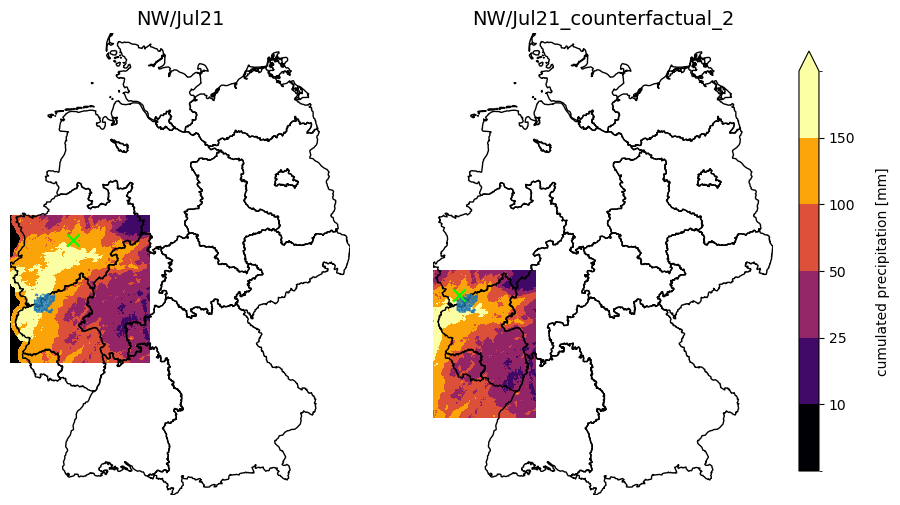

In [13]:
cp.plot_counterfactual(2)

## References

*Chwala, C.: radolan_to_netcdf, GitHub [code], https://github.com/cchwala/radolan_to_netcdf (last access: 18 August 2022), 2021.*

*Heistermann, M., Jacobi, S., and Pfaff, T.: An open source library for processing weather radar data (wradlib), Hydrology and Earth System
Sciences, 17, 863–871, https://doi.org/10.5194/hess-17-863-2013, 2013.*

*U.S. Department of Agriculture-Soil Conservation Service: Estimation of Direct Runoff From Storm Rainfall, SCS National Engineering
Handbook, Section 4, Hydrology. Chapter 10, 1972.*

*Winterrath, T., Brendel, C., Hafer, M., Junghänel, T., Klameth, A., Lengfeld, K., Walawender, E., Weigl, E., and Becker, A.: Gauge-adjusted one-hour precipitation sum (RW):, RADKLIM Version 2017.002: Reprocessed gauge-adjusted radar data, one-hour precipitation sums (RW), https://doi.org//10.5676/DWD/RADKLIM_RW_V2017.002, 2018.*